<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float:  left; margin: 10px;">

# Test / Train / Split
---
Week 4 | Lesson 1.2

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- **Describe** test/train/split and cross-validation
- **Explain** why we want to use these validation techniques and how they differ
- **Split** data into testing and training sets using both test/train/split and cross validation and **Apply** both techniques to score a model
- **Decompose** and analyze a learning curve to understand what it is telling us 



Draw on board data points that will lead to severely overfit model. B0 +B1X1 + B1X1^2 + .... B1X1^15

- Ask student to come up and draw line of best fit through every point
- Ask student what R^2 of the model on this data is
- Put a few more data points on board and ask students if they think is still a good model. 

### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 5 min  | [Opening](#opening)  | Topic description  |
| 10 min  | [Introduction](#introduction)   | Topic description  |
| 15 min  | [Demo](#demo)  | Topic description  |
| 25 min  | [Guided Practice](#guided-practice<a name="opening"></a>)  | Topic description  |
| 25 min  | [Independent Practice](#ind-practice)  | Topic description  |
| 5 min  | [Conclusion](#conclusion)  | Topic description  |

---

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
%matplotlib inline

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a name="introduction"></a>
## Introduction: Topic (10 mins)

Let's review what bias and variance looks like when we try to fit a polynomial to a distribution of data points. We'll make three observations:

1. Underfitting
2. Optimal Fitting
3. Overfitting
4. Which metric to use to score a model's ability to fit a data set. 

Then we'll return to this example when we reach Cross Validation later in the lesson.

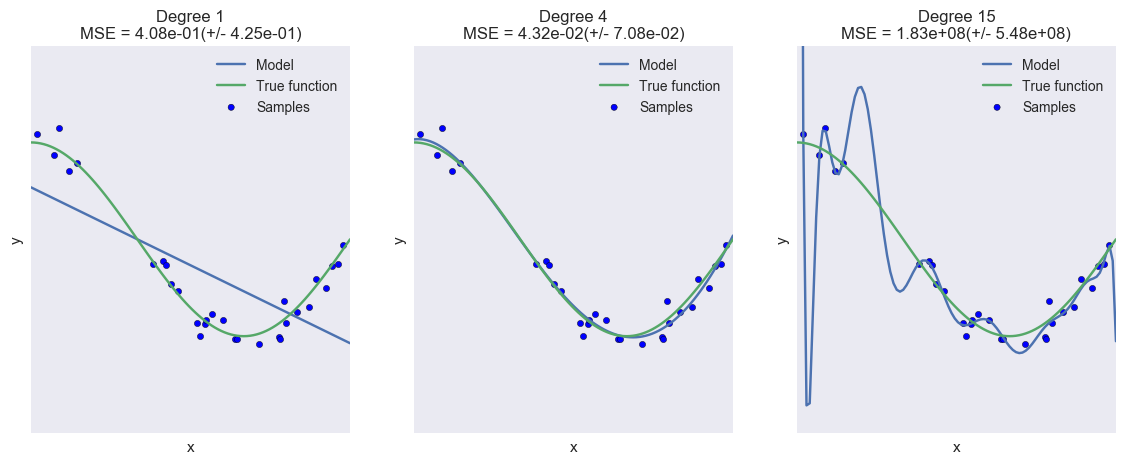

In [2]:
# show example of polynomial underfitting and overfitting

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]
R_2_scores = []

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)

    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()


### The Bias/Variance Error Curve
![Bias_Variance_Curve](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

**CHECK: Why use MSE and not R-Squared? ** 

Mention how the metric $\mathbf{R^{2}}$ is insufficient to determine which complexity of the model is best suited to model the data. 

Mention how knowing the **confidence interval** of the predictor says nothing about complexity of the model is best suited to model the data

[R-Squre is Misleading](https://onlinecourses.science.psu.edu/stat501/node/258) R-squre only tells you if your linear model does a better job of explaining data variance than the data mean (the baseline model). It says nothing about if your model is actually doing a better job at fitting the data than another model.

Ask class what is wrong with first model.
- Severeley underfit model is very high bias. Our model falls short of true model of data

Ask class what is wrong with third model.
- Severely overfit model is very high variance. If we were to feed new data into this model it could look drastically different

Middle model is a good compromise. 

## Train/Train Split
We need
to also make and **validate predictions** with our models. By **splitting our data** set
into a **subset to train our model** on and a **subset to make and test predictions**
on, we can **validate the effectiveness** of our model. This is called a **_train/test
split_** and we'll explore a number of ways to effectively carry out the split.
It's also a good way to avoid overfitting on your dataset (but not always).

**Test/train split benefits:**
* By saving a subset of data to make predictions you can verify predictions without having to collect new data **(which may be difficult or expensive)**
* Can help avoid overfitting
* Improve the quality of our predictions


In [3]:
boston_data = load_boston()
cols_names = boston_data.feature_names
X = boston_data.data

In [4]:
df = pd.DataFrame(X,columns = cols_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [39]:
# for simple linear regression assign a single predictor to X
X = df.RM.values
Y = boston_data.target

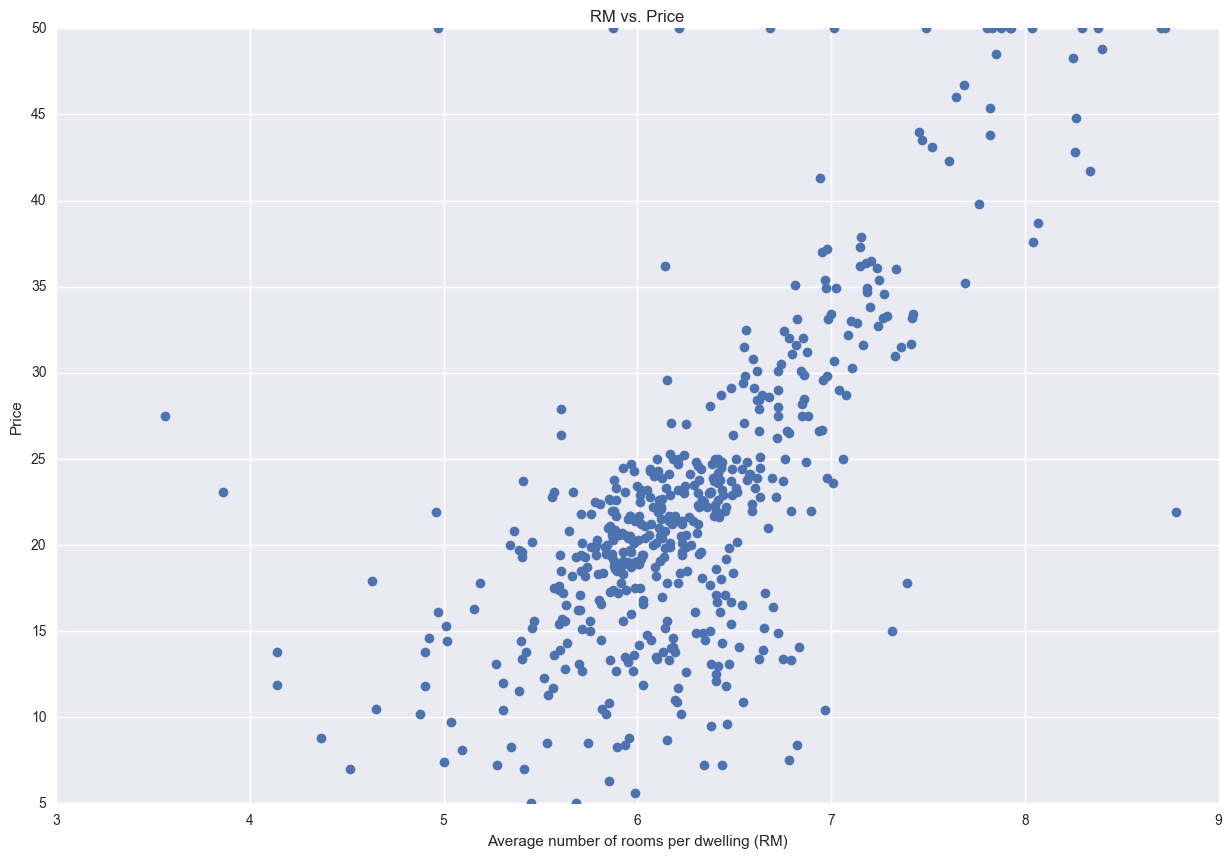

In [40]:
fig = plt.figure(figsize = (15,10))
plt.title("RM vs. Price")
plt.ylabel("Price")
plt.xlabel("Average number of rooms per dwelling (RM)")
plt.plot(X, Y ,"o");

Check out the docs and read up on what types of parameter train_test_split accepts and what they do  [Sklearn Train/Test Split Docs](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1)

In [8]:
# do to dim mismatch when we have a just one predictor, we need to reshape the vectors -- Sklearn issue
X_train = X_train.reshape((X_train.shape[0], 1))
Y_train = Y_train.reshape((Y_train.shape[0], 1))

X_test = X_test.reshape((X_test.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))   

In [9]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
Y_hat = lr.predict(X_test)
mse = mean_squared_error(Y_test, Y_hat)
R_2 = lr.score(X_train,Y_train)

In [10]:
def make_chunks(X, chunk_size = 10, chunk_spacings = 10):
    '''Partitions data into chunks for incremental cross validation'''

    # get total number of points
    N_total = X.shape[0] 
    # partition data into chunks for learning
    chunks = list(np.arange(chunk_size, N_total, chunk_spacings ))
    remainder = X.shape[0] - chunks[-1]
    chunks.append( chunks[-1] + remainder )
    return chunks

In [11]:
def cross_validate(model, X_train, X_test, Y_train, Y_test):
    '''Cross validates model by collecting the Mean Squre Error 
       of the training and test set, as the traning set incementally increases'''
    
    Y_train = Y_train.reshape((Y_train.shape[0], 1))
    # create evenly spaced chucks used to incrementally increase the training set 
    chunks = make_chunks(X_train)
    
    mse_train = []
    mse_test = []

    for n in chunks:
        # incremently increase the training set size by n points in each iteration
        x_train = X_train[0:n]
        y_train = Y_train[0:n]
        
        x_train = x_train.reshape((x_train.shape[0], 1))
        y_train = y_train.reshape((y_train.shape[0], 1))
        
        X_test = X_test.reshape((X_test.shape[0], 1))
        Y_test = Y_test.reshape((Y_test.shape[0], 1))
        
        # fit the model (i.e. find the best parameters)
        model.fit(x_train, y_train)
        
        # get mse for training data
        y_hat = model.predict(x_train)
        mse = mean_squared_error(y_train, y_hat)
        mse_train.append(mse)
        
        # get mse for test data
        y_hat = model.predict(X_test)
        mse = mean_squared_error(Y_test, y_hat)
        mse_test.append(mse)

    return mse_train, mse_test,chunks

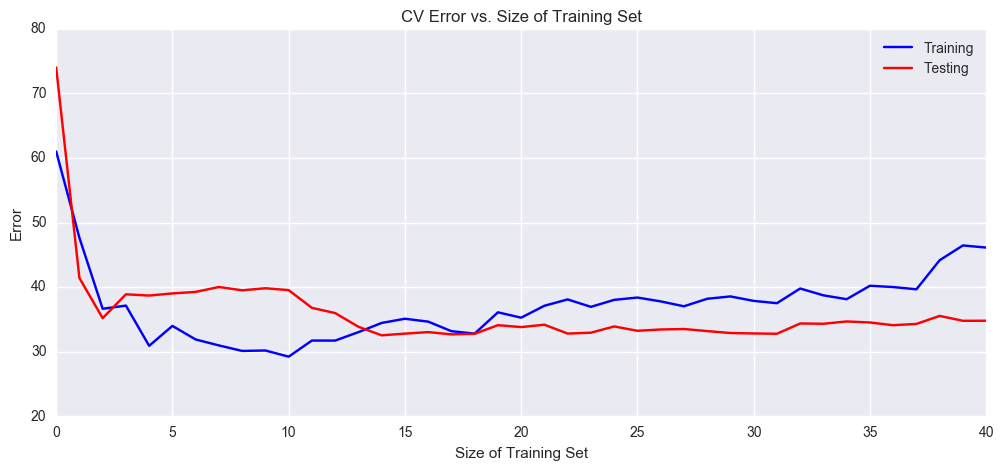

In [12]:
# split data into 80% training and 20% holdout - a 80/20 split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1234)

# create LR object
lr = LinearRegression()
# cross validate 
mse_train, mse_test, chunks = cross_validate(lr, X_train, X_test, Y_train, Y_test)

plt.figure(figsize = (12,5))
plt.title("CV Error vs. Size of Training Set")
plt.ylabel("Error")
plt.xlabel("Size of Training Set")
plt.plot(mse_train, 'b-', label = "Training");
plt.plot(mse_test,'r-', label = "Testing");
plt.legend();

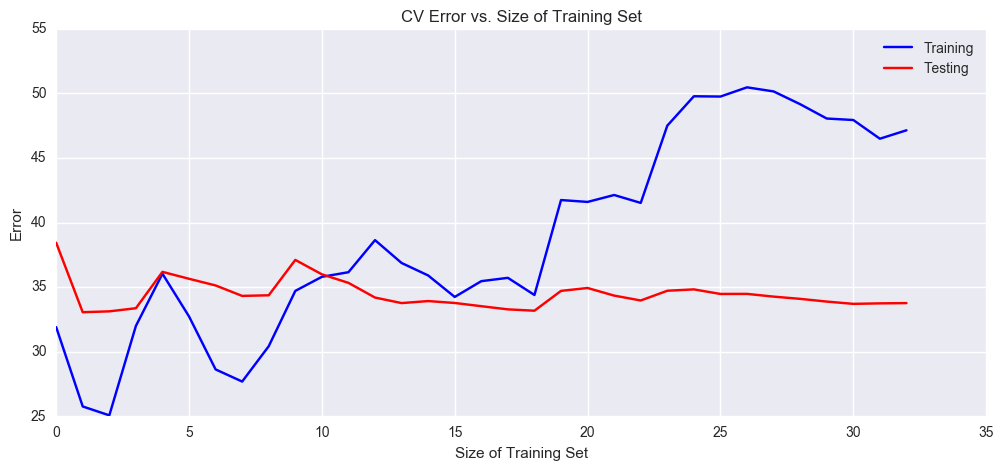

In [13]:
# split data into 80% training and 20% holdout - a 80/20 split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1)

# create LR object
lr = LinearRegression()
# cross validate 
mse_train, mse_test, chunks = cross_validate(lr, X_train, X_test, Y_train, Y_test)

# plot results
plt.figure(figsize = (12,5))
plt.title("CV Error vs. Size of Training Set")
plt.ylabel("Error")
plt.xlabel("Size of Training Set")
plt.plot(mse_train, 'b-', label = "Training");
plt.plot(mse_test,'r-', label = "Testing");
plt.legend();

**Check: ** Why are the plots so different from each other?

## A quick note about "Hold Out" validation

Briefly, sometimes you'll hear about "hold out" validation.  Essentially, you ommit a section of data from any validation setup, in order to truly test unknown data against your model.

The main reason you might try this:

- Test your "winning" model against truly clean data
- "Truly clean" is data a model has never seen 


## About Cross-Validation

We use cross-validation to sample our data in order to understand how it may perform in a variety of cases, given a set of parameters.  It also helps us understand how predictions react to data.  Largely, we are "testing" how our model stands up to basic assumptions, given a model.

Why Validate? 

- Test the model
- Avoid overfitting
- See how well a model generalizes to an independet dataset

The goal of cross validation is to define a dataset to "test" the model in the training phase (i.e., the validation dataset), in order to limit problems like overfitting, give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem), etc.

![](https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_03.png)

## K-Fold Validation

Essentially, K-Fold splits our dataset up into K-Folds, and uses one segment to test.

- Split data into K folds (subsets)
- Use K-1 for training
- Use 1 for testing
- Repeat K times using the next segment for testing each time
- Mean results


Draw 3 folds on board and have student come up and fill in training and test folds. Emphasize that all of the data is included in training 2 of the 3 models. 

## K-Fold Validation In Action

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500"a>

In K-fold cross validation, we follow the same cross validation workflow as in the Train/Test senario, but we iterate through the data K number of times for each parameter combination. By doing this, we ensure the resulting scores of the models will not rely on how we split the data; when spliting data, points are randomly assingment to either the train or test data sets. K-Fold cross validation allows the model to test on every single point, just at different times. As well as allow the model to predict the value of every single point, just at different times. 


![](http://karlrosaen.com/ml/learning-log/2016-06-20/k-fold-diagram.png)

**Check**:  Is 2-fold cross-validation the same as a 50:50 test/train split?  


Let's plot the same two learning curves from above, but know we'll use KFold CV. 

In [14]:
def cross_validate_KFoid(model, n_splits, X, Y, kfold_randstate = 1234):
    '''Cross validates model by collecting the Mean Squre Error 
       of the training and test set, as the traning set incementally increases'''
    
    #Y_train = Y_train.reshape((Y_train.shape[0], 1))
    # create evenly spaced chucks used to incrementally increase the training set 
    chunks = make_chunks(X)
    
    # create kfold object for data splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_randstate)
    
    mse_train = []
    mse_test = []

    for n in chunks:
        
        X = X.reshape((X.shape[0], 1))
        Y = Y.reshape((Y.shape[0], 1))
        
        
        for train_index, test_index in kf.split(X[:n]):

            X_train = X[train_index]
            X_test = X[test_index]
            Y_train = Y[train_index]
            Y_test = Y[test_index]
         
            model.fit(X_train, Y_train)
            y_hat_train = model.predict(X_train)
            y_hat_test = model.predict(X_test)
            
            
            mse = mean_squared_error(Y_train, y_hat_train)
            mse_train.append(mse)
            
            mse = mean_squared_error(Y_test, y_hat_test)
            mse_test.append(mse)
            

    return mse_train, mse_test, chunks

In [15]:
mse_train, mse_test, chunks = cross_validate_KFoid(lr, 10, X, Y, kfold_randstate = 4)

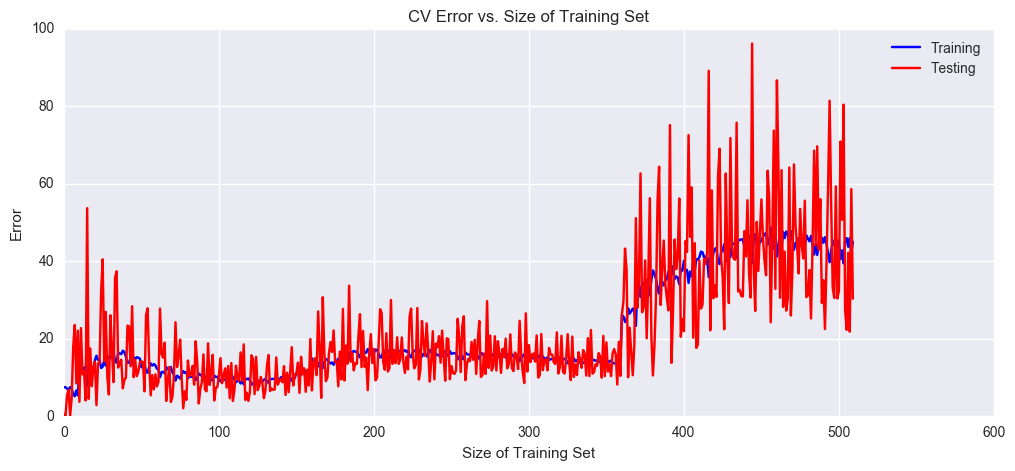

In [16]:
plt.figure(figsize = (12,5))
plt.title("CV Error vs. Size of Training Set")
plt.ylabel("Error")
plt.xlabel("Size of Training Set")
plt.plot(mse_train, 'b-', label = "Training");
plt.plot(mse_test,'r-', label = "Testing");
plt.legend();

In [17]:
mse_train, mse_test, chunks = cross_validate_KFoid(lr, 10, X, Y, kfold_randstate = 1)

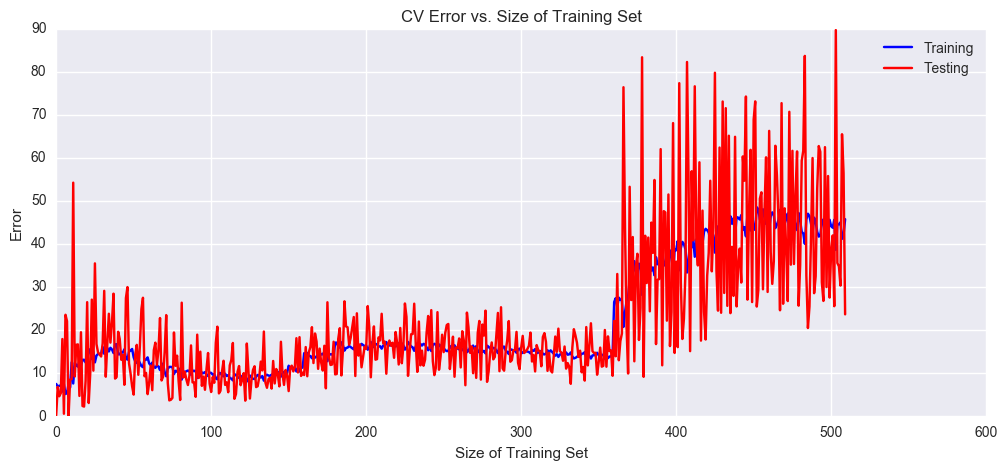

In [18]:
plt.figure(figsize = (12,5))
plt.title("CV Error vs. Size of Training Set")
plt.ylabel("Error")
plt.xlabel("Size of Training Set")
plt.plot(mse_train, 'b-', label = "Training");
plt.plot(mse_test,'r-', label = "Testing");
plt.legend();

**Check: ** Why is there a increase in both the training and test error for our houseing data set?

### Example with Linearly Distributed Data

Let's see what the learning curve looks like with data that is truely linearly distributed and has normally distributed noise/irriducible error.

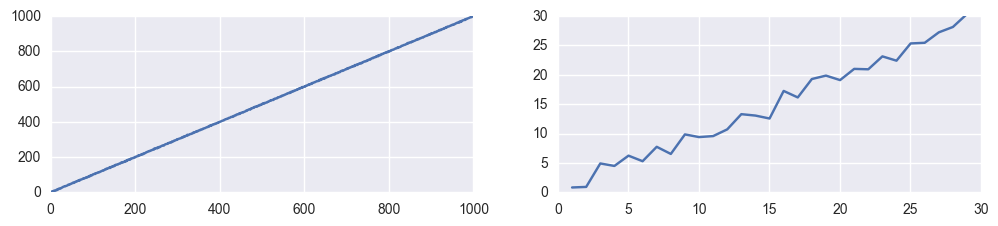

In [77]:
mu= 0, 
sigma = 1
Y = np.linspace(1,1001,1000) + np.random.normal(mu, sigma, 1000)
X = np.linspace(1,1001,1000) 
fig = plt.figure(figsize=(12,5))
fig.add_subplot(221)
plt.xlim(0,1000)
plt.plot(X,Y);

fig.add_subplot(222)
plt.xlim(0,30)
plt.ylim(0,30)
plt.plot(X,Y);

In [78]:
# kfold CV on noise linear data
mse_train, mse_test, chunks = cross_validate_KFoid(lr, 10, X, Y, kfold_randstate = 1)

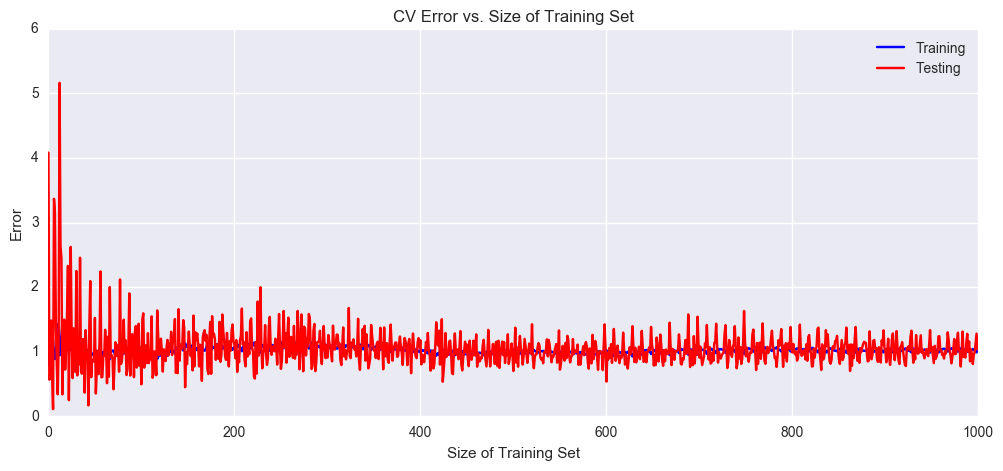

In [85]:
plt.figure(figsize = (12,5))
plt.title("CV Error vs. Size of Training Set")
plt.ylabel("Error")
plt.xlabel("Size of Training Set")
plt.plot(mse_train, 'b-', label = "Training");
plt.plot(mse_test,'r-', label = "Testing");
plt.legend();

# How to Read Learning Curves


Now that we know how to cross validate models by spliting data into train/test/holdout sets and using KFold to eliminate error due to random spliting, let's now use that knowledge to learn how to spot bias and variance in our models by looking at learning curves. 


In total we have three sources of error in our model that comprise the errors of our predictions:

### $$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

### $$E\Big[\big(y - \hat{f}(x)\big)^2\Big] = \text{Bias}\big[\;\hat{f}(x)\;\big]^2 + \text{Var}\big[\;\hat{f}(x)\;\big] + \sigma^2 $$

Where $\hat{f}(x)$ represents our model **across multiple samples of the population $x$, as in, samples $x_1$ through $x_n$**.



### Dart Board Analogy
This graphic shows how various levels and combinations of bias and variance will affect a model's performance. The dart board analogy is a popular graphic used to help people develop an intuitive sense of how bias and variance interact with each other. 

![Bias_Varaince_Dart_Boards](https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAAkaAAAAJDg0MTA0Y2UzLWY5NWUtNGZhMS05ZjgyLTAzNTgyZjc0NjJhMg.jpg)


### Dart Board to Learning Curves

The Drawings below show how the dart board analogy appears on learning curves. We can see that **high bias** literally translate into an estimator predicting values that are consistantly away from the the true values. We can see that **high variance** literally means translates into an estimator predicitng values that are consistantly scattered around the mean of the predicted values. 

**BE CARFUL ! ** The exact order in which the bias/vairance tradeoffs is presented is a little different here than in the dart board drawing. 

![](http://www.ultravioletanalytics.com/wp-content/uploads/2014/12/bias_variance_chart1.jpg)

### Decomposing a Learning Curve

The graphic shows that test error curve at the top and the training error curve at the bottom. The test error curve usually contain more error than the training error. 

**CHECK: ** Why does the test error curve usually contain more error than the train curve?

The training error curve represents the error that is intrinsic to the data. The training error curve represents the error in the model's ability to learn from the training data predict the value of unseen data points. The model's ability to do this is called generalizetion. If a model can generalizetion well, that means that it has successfully learned trends and hidden patterns in past data and can use that insight to predict trends and hidden pattens for data in the future. 


![](https://www.blaenkdenum.com/images/notes/machine-learning/bias-variance-tradeoff/vc-learning-curve.png)


### Yet another interpretation


The vertial axis is error and the horizontal axis is number of training samples. The curve represents testing error and the blue line represents training error. This learning curve is shows a sign of overfitting. The inflection point near middle, where the test curve begins to rise, signifies **overfitting resulting from overtraining**. 


Overfitting resulting from overtraining occurs when the model stops learning about general trends and hidden patterns about the data during training, instead learns how to predict the training data itself. 
![](https://i.stack.imgur.com/hhwyC.png)

## Conclusion

#### Why do we want to use cross validation to test our models?


- To try and avoid overfitting our model
- To make sure our model generalizes well when we use it to predict on new data


#### When to use a Holdout data set?

- When varying a model's complexity by CV several different hyperparameters
- Use Train data to fit the various model parameter combinations
- Use Test data to score the various model parameter combinations
- Finaly, use the holdout set to test the best performing parameter combinations ability to generalize to unseen data

#### What are the two methods for cross validating our models? 

- Test/Train/Split
    - Data is split into training and test sets (80,20, 70/30, 60/40 perhaps) and model is trained on training data (which is then further split into train/test sets) and scored on holdout test data
    - Hodlout data is held out and **NEVER** used in constructing model -- used to test model's ability to generalize
    
- K-Fold Cross Validation
    - Data is split into K folds. Each fold is broken into K segments where K-1 segments are used for training the model with the last segment being used to test the data.
    - Every segment is used as test data once and as training data K-1 times
    - The model will eventually see every data point
    - A Hold out set should also be used to test model's ability to generalize 

# RESOURCES 


- [Experimental Support for K = 10](https://www.researchgate.net/publication/220056065_Measuring_the_prediction_error_A_comparison_of_cross-validation_bootstrap_and_covariance_penalty_methods) Reseachers validate that the optimum number of folds is 10.

- [Plotting Cross-Validated Predictions](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html) A simple and short example of using Sklearn's implementation of cross validation to validate a model (CODE INCLUDED!)

- [Sklearn Advice on Learning Curves](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/practical.html) Breif analysis on how to read learning curves and how to spot bias and variance 

- [Sklearn Learning Cruve Example](http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html) Read made exampe that evauluates a model's errors and plots (CODE INCLUDED!)

- [Sklearn's Learning Cruve Implementation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve) Docs's on Sklearn's built-in function for getting the training and testing error results from your model, which you can then use to plot a learning curve. 

- [Reserach Article: Analysis on Cross Validation](http://leitang.net/papers/ency-cross-validation.pdf) This article goes into detail about which cross validation methods perform better than others, which types of error they tend do well with, and type of erros they tend to perform poorly with (think Type 1 and Type 2 errors).
